In [7]:
# imports 

import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import uuid

from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten 
import tensorflow as tf

In [8]:
# Set GPU memory growth 

# Avoid OOM error by setting GPU Memroy Consumption Growth

gpus = tf.config.experimental.list_physical_devices('GPU') # access the gpus available on the machine
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) # set the memory growth to true for each gpu
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')) , gpus) 

Num GPUs Available:  1 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
# use the tf.data.Dataset API to load the data

# generator to take in the image paths (NOT IMAGES YET)
base = tf.data.Dataset.list_files('data/base/*.jpg').take(300)
pos = tf.data.Dataset.list_files('data/positive/*.jpg').take(300)
neg = tf.data.Dataset.list_files('data/negative/*.jpg').take(300)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [10]:
# understanding generators

test = base.as_numpy_iterator()
print(next(test))

b'data/base/37c430b4-d460-11ed-90fb-da9b0d5c3ef1.jpg'


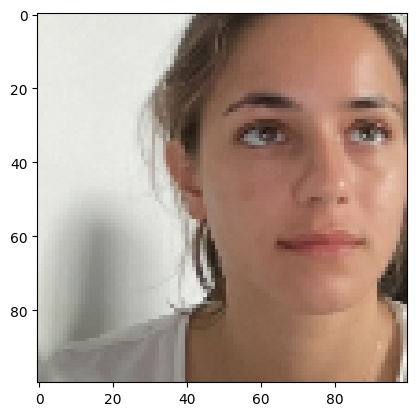

In [11]:
 
def preprocess_image(path): 
    """
    
    This function takes in a path to an image and returns a tensor of the image

    Parameters
    ----------
    path : str
        path to the image

    Returns
    -------
    img : tensor
    """

    bimg = tf.io.read_file(path) # read the file
    img = tf.image.decode_jpeg(bimg) # decode the image
    img = tf.image.resize(img, (100,100)) # resize the image
    img = img/255.0 # normalize the image
    return img

# testing to understand the output of the preprocess stage
img = preprocess_image('data/base/29cd6bc4-d460-11ed-90fb-da9b0d5c3ef1.jpg')
plt.imshow(img)

In [12]:
# Generate a labeled dataset

positives = tf.data.Dataset.zip((base, pos,  tf.data.Dataset.from_tensor_slices(tf.ones(len(base)))))
negatives = tf.data.Dataset.zip((base, neg,  tf.data.Dataset.from_tensor_slices(tf.zeros(len(base)))))
dataset = positives.concatenate(negatives)


In [13]:
dataset

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [14]:
# lets look at one instance of a data point

for i in dataset.take(1):
    print(i)
    unit = i

(<tf.Tensor: shape=(), dtype=string, numpy=b'data/base/22c0a5b2-d460-11ed-90fb-da9b0d5c3ef1.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data/positive/5ed442c0-d460-11ed-90fb-da9b0d5c3ef1.jpg'>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)


In [15]:
def preprocess_twin(input, validation, label): 
    return (preprocess_image(input), preprocess_image(validation), label)

In [16]:
res = preprocess_twin(*unit) # unpack the tuple
print(len(res))



3


In [17]:
# Data Pipeline 

data = dataset.map(preprocess_twin) # preprocess the data 
data = data.cache() # why do we need to cache the data? Because we are using a generator and we want to avoid the overhead of generating the data each time
data = data.shuffle(buffer_size = 1024) # shuffle the data the buffer size is the number of elements to shuffle

In [18]:

# samples = data.as_numpy_iterator()
# # lets check 

# test =  next(samples)
# plt.imshow(test[0])
# plt.imshow(test[1])
# print(test[2])



In [19]:
# Split the data 
traind = data.take(round(len(data)*0.7)) # takes 70% of the data
traind = traind.batch(16) # batch the data in batches of 16
traind = traind.prefetch(8) # starts preprocessing the next batch while the current batch is being trained 

In [20]:
sample = traind.as_numpy_iterator()
test = next(sample)
print(test[0].shape)

(16, 100, 100, 3)


2023-04-06 22:02:57.252254: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


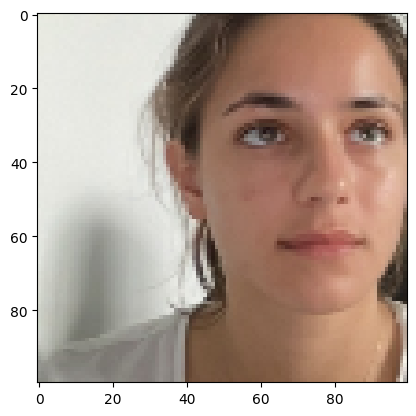

In [21]:
plt.imshow(test[0][0])

0.0


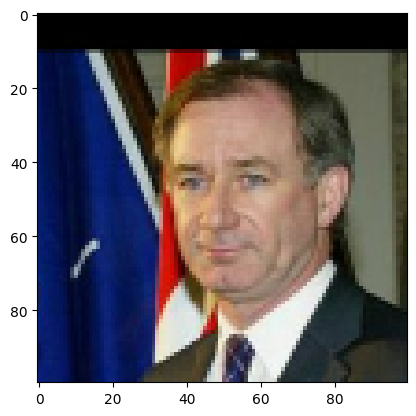

In [22]:
# print the first tuple of the batch

plt.imshow(test[1][0])
print(test[2][0])

In [23]:
testd = dataset.skip(round(len(data)*0.7)) #skip the first 70% of the data
testd = testd.take(round(len(data)*0.3)) # takes 30% of the data
testd = testd.batch(16) # batch the data in batches of 16
testd = testd.prefetch(8) # starts preprocessing the next batch while the current batch is being trained


### Building the Model

1. Embedding Layer
2. Create an L1 Distance Layer
3. Create a Siamese Network



In [24]:
def make_embeddings():
    """
    This function creates the embedding layer for the siamese network
    """
    # input layer image size 100x100x3
    inp = Input(shape=(100,100,3), name= 'input image')


    # BLOCK 1
    # convolution + RELU Activation [64 @ 10x10 Convolution takes the amount of filters and the size of the filer ], stride = 1
    c1 = Conv2D(64, (10,10), activation='relu', name='conv1')(inp)
    # max-pooling [2x2] stride = 2 - padding should be the same to replicate same output shape 
    m1 = MaxPooling2D(64, (2,2), padding ='same', name='maxpool1')(c1)

    # BLOCK 2
    c2 = Conv2D(128, (7,7), activation='relu', name='conv2')(m1)
    m2 = MaxPooling2D(128, (2,2), padding ='same', name='maxpool2')(c2)

    # BLOCK 3
    c3 = Conv2D(128, (4,4), activation='relu', name='conv3')(m2)
    m3 = MaxPooling2D(64, (2,2) , padding ='same', name='maxpool3')(c3)

    # Final BLOCK
    c4 = Conv2D(256, (4,4), activation='relu', name='conv4')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid', name='dense1')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding_layer')




In [25]:
embedding = make_embeddings()
embedding.summary()

Model: "embedding_layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 91, 91, 64)        19264     
                                                                 
 maxpool1 (MaxPooling2D)     (None, 46, 46, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 40, 40, 128)       401536    
                                                                 
 maxpool2 (MaxPooling2D)     (None, 20, 20, 128)       0         
                                                                 
 conv3 (Conv2D)              (None, 17, 17, 128)       262272    
                                                                 
 maxpool3 (MaxPooling2D)     (None, 9, 9, 128)     

In [26]:
# create the L1 distance layer

class L1Dist(Layer): 
    def __init__(self, **kwargs): 
        super().__init__() # inheritance of base methods

    def call(self, input_emb, validation_emb): 
        return tf.math.abs(input_emb - validation_emb) # similirity comparison
        

l1 = L1Dist()
    

In [27]:
def create_model(): 
    # base image
    input_image = Input(shape=(100,100,3), name='input_image')
    # sample
    validation_image = Input(shape=(100,100,3), name='validation_image')

    sim = L1Dist()
    sim._name = 'similarity'

    distances = sim(embedding(input_image), embedding(validation_image))

    classification = Dense(1, activation='sigmoid', name='classification')(distances)

    return Model(inputs=[input_image, validation_image], outputs=[classification], name='siamese_network')

model = create_model()
model.summary()

    

Model: "siamese_network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding_layer (Functional)   (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'validation_image[

In [28]:
# training 

# loss function 
binary_crossentropy = tf.losses.BinaryCrossentropy()
optimizer = tf.optimizers.legacy.Adam(learning_rate=0.0001)


In [29]:
# Establish Checkpoints

checkpoint_path = "./training_checkpoints"
if not os.path.exists(checkpoint_path):
    os.mkdir(checkpoint_path)

cprefix = os.path.join(checkpoint_path, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_path, max_to_keep=3)


In [30]:
test = traind.as_numpy_iterator()
batch = next(test)

In [31]:
X = batch[:2] 
len(X[0])

16

In [32]:
y = batch[2]
y

array([1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1.],
      dtype=float32)

In [33]:
# Train Step 

# how you train one batch of data
# 1. Get A batch of data
# 2. make pred
# 3. Calculate the loss
# 4. Calculate the gradients
# 5. Apply the gradients to the model through backpropagation
# 6. Return the loss

@tf.function
def train_step(batch): 
    with tf.GradientTape() as tape: # used to calculate the gradients by capturing the operations that are done on the variables
        X = batch[:2] # get the first two elements of the batch which were input and validation images
        y = batch[2] # get the last element of the batch which is the label 
        # note that each batch consists of 16 samples each of which is a tuple of 3 elements (input, validation, label)
        pred = model(X, training=True) # make a prediction 
        loss = binary_crossentropy(y, pred) # calculate the loss
    
    # Calculating the gradients
    gradients = tape.gradient(loss, model.trainable_variables) # calculate the gradients
    # calculatingthe updated weights and apply them
    optimizer.apply_gradients(zip(gradients, model.trainable_variables)) # apply the gradients to the model

    return loss
    


In [34]:

from tensorflow.keras.metrics import Precision, Recall




In [35]:
# Training Loop

def train(data, EPOCHS):
    # LOOP OVER EPOCHS
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progress = tf.keras.utils.Progbar(len(data)) # progress bar
        # LOOP OVER BATCHES
        # mtrics
        r = Recall()
        p = Precision()
        
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            pred = model.predict(batch[:2])
            r.update_state(batch[2], pred)
            p.update_state(batch[2], pred)
            progress.update(idx+1, values=[('loss', loss), ('recall', r.result()), ('precision', p.result())])
        
        # save the model after each epoch
        if (EPOCH % 10) == 0:
            checkpoint.save(file_prefix=cprefix)

    return model



In [30]:

EPOCH = 4 # i only trained it for 4 epochs in this case to save time and generate PoC results 
train(traind, EPOCH)


 Epoch 1/4
27/27 [==============================] - 81s 3s/step - loss: 0.5238 - recall: 0.1925 - precision: 0.9871

 Epoch 2/4
27/27 [==============================] - 80s 3s/step - loss: 0.2760 - recall: 0.7880 - precision: 0.9270

 Epoch 3/4
27/27 [==============================] - 96s 4s/step - loss: 0.2235 - recall: 0.9113 - precision: 0.9503

 Epoch 4/4
27/27 [==============================] - 105s 4s/step - loss: 0.1979 - recall: 0.9300 - precision: 0.9685


In [ ]:
# # load model from checkpoint 

# model = create_model()
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))
# model.summary()

Model: "siamese_network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding_layer (Functional)   (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'validation_image[

In [31]:
# check the model weights
model.get_weights()

[array([[[[ 3.09810266e-02,  1.73236653e-02, -1.31773343e-02, ...,
           -4.88785235e-03,  2.30537914e-02,  1.07234921e-02],
          [ 6.90151844e-03,  1.19658001e-02,  2.45192647e-02, ...,
           -6.09159609e-03,  2.22379360e-02,  1.43200764e-02],
          [ 7.14480272e-03, -1.31709753e-02,  1.21600144e-02, ...,
            7.77697470e-03,  2.42023468e-02,  7.61175761e-03]],
 
         [[-2.52900571e-02, -1.93806816e-04, -1.29590565e-02, ...,
            2.60650255e-02,  1.93455424e-02, -9.88064893e-03],
          [-4.65249736e-03,  1.16122449e-02,  1.81159023e-02, ...,
           -2.37269439e-02,  3.03712785e-02, -9.00260359e-03],
          [ 1.19077303e-02, -4.67525423e-03, -9.48800892e-03, ...,
            1.95351113e-02,  2.73397402e-03, -1.29600288e-02]],
 
         [[ 2.48950999e-02,  2.33895481e-02,  1.21363541e-02, ...,
            2.29523517e-02, -8.30888096e-03, -5.75198466e-03],
          [-2.59500407e-02, -1.55509897e-02, -3.35172564e-03, ...,
           -2.793

In [32]:
batch = testd.as_numpy_iterator().next()



In [38]:
pred = model.predict(batch[:2])

1/1 [==============================] - 0s 24ms/step


In [39]:
[1 if i > 0.5 else 0 for i in pred]


[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1]

In [40]:
batch[2]

array([0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.],
      dtype=float32)

In [65]:
# Model Evaluation
test = data.skip(round(len(data)*0.7)) #skip the first 70% of the data
test = test.batch(16) # batch the data in batches of 16
test = test.prefetch(8) # prefetch the data

In [67]:
r = Recall()
p = Precision()


# generator loop 
for i in range(len(test)):
    batch = test.as_numpy_iterator().next()
    pred = model.predict(batch[:2])
    r.update_state(batch[2], pred)
    p.update_state(batch[2], pred)

print('Recall: ', r.result().numpy())
print('Precision: ', p.result().numpy())
    

    

1/1 [==============================] - 0s 15ms/step
Recall:  0.8846154
Precision:  1.0


In [69]:
model.save('binary_siamese_network_light.h5')

In [70]:
# # load model from checkpoint

model_9 = create_model()
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))
model_9.summary()

Model: "siamese_network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding_layer (Functional)   (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'validation_image[

In [71]:
for i in range(len(test)):
    batch = test.as_numpy_iterator().next()
    pred = model_9.predict(batch[:2])
    r.update_state(batch[2], pred)
    p.update_state(batch[2], pred)

print('Recall: ', r.result().numpy())
print('Precision: ', p.result().numpy())
    

1/1 [==============================] - 0s 14ms/step
Recall:  0.69897956
Precision:  0.9513889


Recall measures the proportion of true positive cases that are correctly identified by the model, while precision measures the proportion of true positive cases among all the cases that the model identified as positive.

If the goal is to minimize false negatives (i.e., identify as many true positives as possible), then the model with the higher recall value would be preferable. On the other hand, if the goal is to minimize false positives (i.e., only identify true positives and avoid false positives), then the model with the higher precision value would be preferable.

In [61]:


# Reload model 
model = tf.keras.models.load_model('binary_siamese_network.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})
# compile the model



In [62]:
# first there is a function which does a probe through all the people that exist in the database
# it takes the input image and compares it with all the images in the database
# the highest similarity score goes on to the next step 
# verification step 


In [ ]:
https://towardsdatascience.com/a-beginners-guide-to-building-your-own-face-recognition-system-to-creep-out-your-friends-df3f4c471d55


In [ ]:
# first take one image from the input 
# then compare it with all the images in the database
# then take the highest similarity score and compare it with the threshold


In [66]:


def verify(model, detection_treshold, verification_threshold): 
    results = []
    # geneate a 1xN matrix of verification image to compare with the input image wher N is the number of images in the database
    # the highest similarity score goes on to the next step
    matrix = np.zeros((1, len(os.listdir('application/verification'))))
    # generate a matrix of verification images to compare with the input image
    # the highest similarity score goes on to the next step
    for img in os.listdir('application/verification'):
        for person in os.listdir('application/input'):
            # load the input image and the verification image
            input_img = preprocess_image(os.path.join('application', 'input', person))
            verification = preprocess_image(os.path.join('application', 'verification', img))
            res = model.predict(list(np.expand_dims([input_img, verification], axis=1)))

    

        results.append(res)
        tracking.append(img)


    det = np.sum(np.array(results) > detection_treshold)
    ver = det / len(os.listdir('application/verification'))
    verified = ver > verification_threshold

    return results, verified, tracking

In [67]:
res = verify(model, 0.5, 0.5)


1/1 [==============================] - 0s 14ms/step


In [68]:
avg_results = np.mean(np.array(res[0]), axis=0)
avg_results

array([[0.81350654]], dtype=float32)

In [69]:
res[0]

[array([[0.51102674]], dtype=float32),
 array([[0.6638017]], dtype=float32),
 array([[0.9852453]], dtype=float32),
 array([[0.97559595]], dtype=float32),
 array([[0.37487668]], dtype=float32),
 array([[0.985784]], dtype=float32),
 array([[0.5178594]], dtype=float32),
 array([[0.98585176]], dtype=float32),
 array([[0.9894589]], dtype=float32),
 array([[0.8036955]], dtype=float32),
 array([[0.9933646]], dtype=float32),
 array([[0.97551686]], dtype=float32)]

In [70]:
res[2]

['4dba5eb6-d460-11ed-90fb-da9b0d5c3ef1.jpg',
 '4d2c72d6-d460-11ed-90fb-da9b0d5c3ef1.jpg',
 'to_verify.jpg',
 '4f1944c0-d460-11ed-90fb-da9b0d5c3ef1.jpg',
 '4d731182-d460-11ed-90fb-da9b0d5c3ef1.jpg',
 '4cefb094-d460-11ed-90fb-da9b0d5c3ef1.jpg',
 '4d923328-d460-11ed-90fb-da9b0d5c3ef1.jpg',
 '4e168b8c-d460-11ed-90fb-da9b0d5c3ef1.jpg',
 '4f4213e6-d460-11ed-90fb-da9b0d5c3ef1.jpg',
 '4dedd73c-d460-11ed-90fb-da9b0d5c3ef1.jpg',
 '4e3e5ed2-d460-11ed-90fb-da9b0d5c3ef1.jpg',
 '4d0d9938-d460-11ed-90fb-da9b0d5c3ef1.jpg']

In [ ]:
# as we can see there there are varying verification probabilities (similarity scores) for each image verified against...
# Effectively this means if we do a 2-step verification workflow, in which for one, we check if a person is in the databse, and 2 if they are 'verified' we produce the highest similarity score,
# that in theory should yield us with a person 

